In [1]:
# install/import lspi package
try:
    import lspi
except ImportError:
    !pip install git+https://github.com/qdevpsi3/rl-lspi.git
    import lspi

In [2]:
import numpy as np

# Experiment 2 : LSPI on the *Inverted-Pendulum* environment
---------- 
First, we create a function that takes as input a policy and computes the average number of balancing steps.

In [3]:
def score(agent):
    _, episode_lengths = lspi.utils.evaluate_policy(agent,
                                                    agent.env,
                                                    max_length=3000,
                                                    n_eval_episodes=10
                                                    )
    return int(np.mean(episode_lengths))

We perform *LSPI* with RBF features : $9$ means spanning the grid $\{-\pi/4,0,+\pi/4\}\times\{-1,0,+1\}$ and variance $\sigma=1$.

## Experiment 2.1 : *Inverted-Pendulum* environment for $1000$ episodes 
For the first experiment, the agent collect samples by playing for $1000$ episodes.

In [4]:
# build the environment
nA = 3
env = lspi.envs.InvertedPendulumEnv(nA)

# build the agent
grids = [[-np.pi / 4., 0., np.pi / 4], [-1., 0., 1.]]
centers = lspi.agents.RadialAgent.get_centers_from_grids(grids)
sigma = 1.
agent = lspi.agents.RadialAgent(env, centers, sigma)

# build the trainer
gamma = 0.95
memory_size = 1000
memory_type = 'episode'
eval_type = 'batch'
baseline = lspi.baselines.LSPolicyIteration(env, agent, gamma, memory_size,
                                            memory_type, eval_type)

# build the memory
baseline.init_memory()
print('memory size = {}'.format(len(baseline.memory)))

# run the algorithm
n_iter = 10
steps = score(agent)
print('iteration = {:02d} - average number of balancing steps : {:04d}'.format(
    0, steps))
for it in range(1, n_iter + 1):
    baseline.train_step()
    steps = score(agent)
    print('iteration = {:02d} - average number of balancing steps : {:04d}'.
          format(it, steps))

memory size = 8506
iteration = 00 - average number of balancing steps : 0005
iteration = 01 - average number of balancing steps : 0010
iteration = 02 - average number of balancing steps : 3000
iteration = 03 - average number of balancing steps : 3000
iteration = 04 - average number of balancing steps : 3000
iteration = 05 - average number of balancing steps : 3000
iteration = 06 - average number of balancing steps : 3000
iteration = 07 - average number of balancing steps : 3000
iteration = 08 - average number of balancing steps : 3000
iteration = 09 - average number of balancing steps : 3000
iteration = 10 - average number of balancing steps : 3000


## Experiment 2.2 : Number of training episodes vs. Score
For the second experiment, we vary the number of training episodes.

In [5]:
range_episodic_memory = np.linspace(50, 1000, 20).astype(int)
n_trials = 10
results = []
for memory_size in range_episodic_memory:
    results.append([])

    # build the trainer
    baseline = lspi.baselines.LSPolicyIteration(env, agent, gamma, memory_size,
                                                memory_type, eval_type)
    for _ in range(n_trials):

        # build the memory
        baseline.init_memory()
        # initialize the agent
        agent.init_weights()

        # run the algorithm
        for it in range(1, n_iter + 1):
            baseline.train_step()
        steps = score(agent)
        results[-1].append(steps)

    print('n_episodes = {:04d} - average number of balancing steps : {:04d}'.
          format(memory_size, int(np.mean(results[-1]))))

n_episodes = 0050 - average number of balancing steps : 1526
n_episodes = 0100 - average number of balancing steps : 0627
n_episodes = 0150 - average number of balancing steps : 1430
n_episodes = 0200 - average number of balancing steps : 1479
n_episodes = 0250 - average number of balancing steps : 1922
n_episodes = 0300 - average number of balancing steps : 2296
n_episodes = 0350 - average number of balancing steps : 2437
n_episodes = 0400 - average number of balancing steps : 1949
n_episodes = 0450 - average number of balancing steps : 2581
n_episodes = 0500 - average number of balancing steps : 2675
n_episodes = 0550 - average number of balancing steps : 2213
n_episodes = 0600 - average number of balancing steps : 2506
n_episodes = 0650 - average number of balancing steps : 2700
n_episodes = 0700 - average number of balancing steps : 2104
n_episodes = 0750 - average number of balancing steps : 2409
n_episodes = 0800 - average number of balancing steps : 2606
n_episodes = 0850 - aver

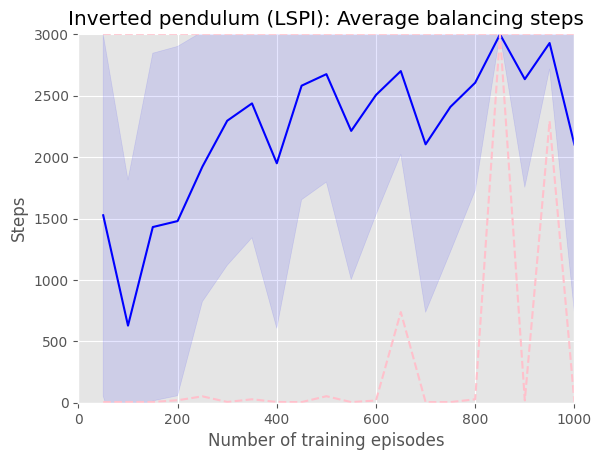

In [6]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.title('Inverted pendulum (LSPI): Average balancing steps')
plt.xlabel('Number of training episodes')
plt.ylabel('Steps')
plt.xlim(0, 1000)
plt.ylim(0, 3010)

x = range_episodic_memory

y_mean = np.mean(results, 1)
plt.plot(x, y_mean, color='blue')

y_max = np.max(results, 1)
plt.plot(x, y_max, '--', color='pink')

y_min = np.min(results, 1)
plt.plot(x, y_min, '--', color='pink')

y_std = np.std(results, 1)
plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='blue', alpha=.1)

plt.show()